# 4- Exploration and importance of features

The goal of this part is to take the gathered data that we collected before and process to obtain a suitable dataframe that corresponds to the different assumptions we will make throughout this project. As our endgoal is to then analyze this dataframe using spectral clustering, we will elect the features that impact the most our success metrics, the economic success and the steam grade, by using a regression method.

First we import the packages we will need : 

In [1]:
import itertools
import re

# third-party imports
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy.spatial.distance import pdist, squareform
from scipy.sparse import csr_matrix

# customisations
pd.set_option("max_columns", 100)
plt.style.use('default')
# customisations
pd.set_option("max_columns", 100)
plt.style.use('default')
plt.rcdefaults()

We import our data of games and their features and load it in a pandas dataframe.

In [2]:
pd_data =pd.read_csv('./data/steam_clean.csv')
pd_data.head()

,appid,name,release_date,english,french,german,developer,publisher,platforms,required_age,categories,genres,steamspy_tags,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,owners,price,economic_success
0,340,Half-Life 2: Lost Coast,2005-10-27,1,1,1,Valve,Valve,windows;mac;linux,0,Single-player;Commentary available;Remote Play...,Action,FPS;Action;Singleplayer,0,6412,1072,123,23,2000000-5000000,0.0,0.0
1,440,Team Fortress 2,2007-10-10,1,1,1,Valve,Valve,windows;mac;linux,0,Multi-player;Cross-Platform Multiplayer;Steam ...,Action;Free to Play,Hero Shooter;Free to Play;Multiplayer,520,588020,37107,8895,452,50000000-100000000,0.0,0.0
2,570,Dota 2,2013-07-09,1,1,1,Valve,Valve,windows;mac;linux,0,Multi-player;Co-op;Steam Trading Cards;Steam W...,Action;Free to Play;Strategy,Free to Play;MOBA;Multiplayer,0,1018172,174020,29989,1284,100000000-200000000,0.0,0.0
3,630,Alien Swarm,2010-07-19,1,0,0,Valve,Valve,windows,0,Single-player;Multi-player;Co-op;Steam Achieve...,Action,Free to Play;Co-op;Action,66,17946,974,319,96,1000000-2000000,0.0,0.0
4,730,Counter-Strike: Global Offensive,2012-08-21,1,1,1,Valve;Hidden Path Entertainment,Valve,windows;mac;linux,0,Multi-player;Steam Achievements;Full controlle...,Action;Free to Play,FPS;Shooter;Multiplayer,167,3295593,470639,25886,7129,20000000-50000000,0.0,0.0


In [3]:
print("This dataframe contains data about", len(pd_data),"games, released ever since the creation of the platform in 2003 \n till the end of 2019.")

This dataframe contains data about 29380 games, released ever since the creation of the platform in 2003 
 till the end of 2019.


# Cleaning

 We will now process the data following these assumptions :
 - Any steam user can either give a positive review or a negative review of a game. [SteamDB](https://steamdb.info/blog/steamdb-rating/) presents a method to come up with a global rating with these reviews that will take into account the number of reviews given. We will implement this grading into a row of our dataframe. 
 - As we consider the success of our games we consider only the games that can be played and understood by a global community, therefore being available in english. All games that are not available in english are removed.
 - We separate the release date into a column for the release year of the game and a column for the release month of the game.
 - We one-hot encode the games' genres and create a column for each to have a 1 in the column when the game belongs to the genre in question.
 - We remove all non-games entries, such as mods and least represented categories on the platform.

In [4]:
def remove_non_language(df):
    # keep only rows marked as supporting english
    df = df[df['english'] ==1 ].copy()
    #df = df[(df['english'])>= 1].copy()
    # keep rows which don't contain 3 or more non-ascii characters in succession
    df = df[~df['name'].str.contains('[^\u0001-\u007F]{3,}')]
    
    # remove english column, now redundant
    df = df.drop(['english', 'french','german'], axis=1)
    
    return df


def calc_rating(row):
    """Calculate rating score based on SteamDB method."""
    import math

    pos = row['positive_ratings']
    neg = row['negative_ratings']

    total_reviews = pos + neg
    average = pos / total_reviews
    
    # pulls score towards 50, pulls more strongly for games with few reviews
    score = average - (average*0.5) * 2**(-math.log10(total_reviews + 1))

    return score * 100


def get_unique(series):
    """Get unique values from a Pandas series containing semi-colon delimited strings."""
    return set(list(itertools.chain(*series.apply(lambda x: [c for c in x.split(';')]))))


def process_cat_gen_tag(df):
    """Process categories, genres and steamspy_tags columns."""
    # get all unique category names
    cat_cols = get_unique(df['categories'])
    
    # only going to use these categories (can uncomment to use others)
    cat_cols = [
        # 'Local Multi-Player',
        # 'MMO',
        # 'Mods',
        'Multi-player',
        # 'Online Co-op',
        # 'Online Multi-Player',
        'Single-player'
    ]
    
    # create a new column for each category, with 1s indicating membership and 0s for non-members
    for col in sorted(cat_cols):
        col_name = re.sub(r'[\s\-\/]', '_', col.lower())
        col_name = re.sub(r'[()]', '', col_name)
        
        df[col_name] = df['categories'].apply(lambda x: 1 if col in x.split(';') else 0)
        
    # repeat for genre column names (get_unique used to find unique genre names, 
    # not necessary but useful if keeping all of them)
    gen_cols = get_unique(df['genres'])
    
    # only keeping 'main' genres similar to steam store
    gen_cols = [
        # 'Accounting',
        'Action',
        'Adventure',
        # 'Animation & Modeling',
        # 'Audio Production',
        'Casual',
        # 'Design & Illustration',
        # 'Documentary',
        # 'Early Access',
        # 'Education',
        # 'Free to Play',
        # 'Game Development',
        # 'Gore',
        'Indie',
        'Massively Multiplayer',
        # 'Nudity',
        # 'Photo Editing',
        'RPG',
        'Racing',
        # 'Sexual Content',
        'Simulation',
        # 'Software Training',
        'Sports',
        'Strategy'
        # 'Tutorial',
        # 'Utilities',
        # 'Video Production',
        # 'Violent',
        # 'Web Publishing'
    ]
    
    gen_col_names = []
    
    # create new columns for each genre with 1s for games of that genre
    for col in sorted(gen_cols):
        col_name = col.lower().replace('&', 'and').replace(' ', '_')
        gen_col_names.append(col_name)
        
        df[col_name] = df['genres'].apply(lambda x: 1 if col in x.split(';') else 0)
        # alternate method using np.where:
        # df[col_name] = np.where(df['genres'].str.contains(col), 1, 0)
    
    # remove "non-games" based on genre
    # if a row has all zeros in the new genre columns, it most likely isn't a game, so remove (mostly software)
    gen_sums = df[gen_col_names].sum(axis=1)
    df = df[gen_sums > 0].copy()
        
    # not using steamspy tags for now, as mostly overlap with genres
    # here's one way we could deal with them:
    # tag_cols = get_unique(df['steamspy_tags'])
    # df['top_tag'] = df['steamspy_tags'].apply(lambda x: x.split(';')[0])
    
    # remove redundant columns and return dataframe (keeping genres column for reference)
    df = df.drop(['categories', 'steamspy_tags'], axis=1)
    
    return df


def pre_process():
    """Preprocess Steam dataset for exploratory analysis."""
    df = pd.read_csv('./data/steam_clean.csv')
    print(len(df))
    # keep english only
    df = remove_non_language(df)
    print(len(df))
    # keep windows only, and remove platforms column
    df = df[df['platforms'].str.contains('windows')].drop('platforms', axis=1).copy()
    print(len(df))
    # keep lower bound of owners column, as integer
    df['owners'] = df['owners'].str.split('-').apply(lambda x: x[0]).astype(int)
    print(len(df))
    
    # calculate rating, as well as simple ratio for comparison
    df['total_ratings'] = df['positive_ratings'] + df['negative_ratings']
    df['rating_ratio'] = df['positive_ratings'] / df['total_ratings']
    df['rating'] = df.apply(calc_rating, axis=1)
    
    # convert release_date to datetime type and create separate column for release_year
    df['release_date'] = df['release_date'].astype('datetime64[ns]')
    df['release_year'] = df['release_date'].apply(lambda x: x.year)
    
    # process genres, categories and steamspy_tag columns
    df = process_cat_gen_tag(df)
    
    
    return df

data = pre_process()
print(len(data))

print('Verify no missing values:')
print(data.isnull().sum().value_counts())

data.head()

29380
28181
28176
28176
27903
Verify no missing values:
0    30
1     1
dtype: int64


,appid,name,release_date,developer,publisher,required_age,genres,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,owners,price,economic_success,total_ratings,rating_ratio,rating,release_year,multi_player,single_player,action,adventure,casual,indie,massively_multiplayer,rpg,racing,simulation,sports,strategy
0,340,Half-Life 2: Lost Coast,2005-10-27,Valve,Valve,0,Action,0,6412,1072,123,23,2000000,0.0,0.0,7484,0.856761,82.754771,2005,0,1,1,0,0,0,0,0,0,0,0,0
1,440,Team Fortress 2,2007-10-10,Valve,Valve,0,Action;Free to Play,520,588020,37107,8895,452,50000000,0.0,0.0,625127,0.940641,93.217574,2007,1,0,1,0,0,0,0,0,0,0,0,0
2,570,Dota 2,2013-07-09,Valve,Valve,0,Action;Free to Play;Strategy,0,1018172,174020,29989,1284,100000000,0.0,0.0,1192192,0.854034,84.770535,2013,1,0,1,0,0,0,0,0,0,0,0,1
3,630,Alien Swarm,2010-07-19,Valve,Valve,0,Action,66,17946,974,319,96,1000000,0.0,0.0,18920,0.948520,92.405605,2010,1,1,1,0,0,0,0,0,0,0,0,0
4,730,Counter-Strike: Global Offensive,2012-08-21,Valve;Hidden Path Entertainment,Valve,0,Action;Free to Play,167,3295593,470639,25886,7129,20000000,0.0,0.0,3766232,0.875037,87.045099,2012,1,0,1,0,0,0,0,0,0,0,0,0


We observed that the owners category gives us very important insights to understand if a game has had any success. 

We study this column in more depth and were able to observe that most of the games in our dataset have less than 20,000 owners, therefore will be considered as non successful. This represents more than two thirds of the data, therefore, could be critical in any analysis we choose to do.

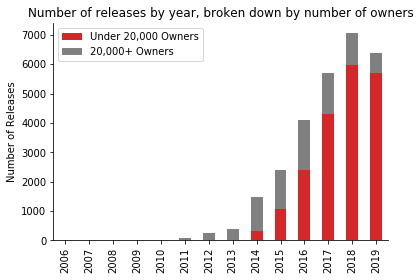

In [5]:
df = data.copy()

years = []
lt_20k = []
gt_20k = []

for year in sorted(df['release_year'].unique()):
    if year < 2006 or year > 2019:
#Most impactful years
        continue
    
    # subset dataframe by year
    year_df = df[df.release_year == year]
    
    # calculate total with less than 20,000 owners, and total with 20,000 or more
    total_lt_20k = year_df[year_df.owners < 20000].shape[0]
    total_gt_20k = year_df[year_df.owners >= 20000].shape[0]
    
    years.append(year)
    lt_20k.append(total_lt_20k)
    gt_20k.append(total_gt_20k)
    
owners_df = pd.DataFrame(zip(years, lt_20k, gt_20k), 
                         columns=['year', 'Under 20,000 Owners', '20,000+ Owners'])

ax = owners_df.plot(x='year', y=[1, 2], kind='bar', stacked=True, color=['tab:red', 'gray'])

ax.set_xlabel('')
ax.set_ylabel('Number of Releases')
ax.set_title('Number of releases by year, broken down by number of owners')
sns.despine()
plt.show()

In this chart, we can observe the number of releases per year, and the repartition of games with more (in grey) or less than 20,000 owners (in red). We take into account the fact the games in the grey region can hold games owned by more than 10 million people.

The main trend we can observe is that ever since 2014, the number of games releases have had a steady growth except for 2019. This is mainly due to the number of games with less than 20,000 owners as the number of games with more than 20,000 owners has stayed fairly constant. The analysis we can make is that the demand has stayed more or less the same from users whilst the offer has increased exponentially, therefore decreasing the proportion of successful games to be.

We have to account for the fact that the latest games will still gain some activity in the coming years so this observation is mainly coherent with data prior 2018.

Moreover, in the latest years, more and more people have become gamers, starting with small games on their mobiles, enjoying spending minutes on small games whenever they have a moment. This format has been trending for more than 5 years now and has propagated on Steam as computer adaptations of mobile games have been released as well as light games that can catch this audience of casual gamers that don't want to spend a lot of time playing on the computer. 


Now that we kept what we consider as the relevant games, we can start observing the data make a new assumption : free games will reach a success differently than premium games (games with a nonzero price tag). 

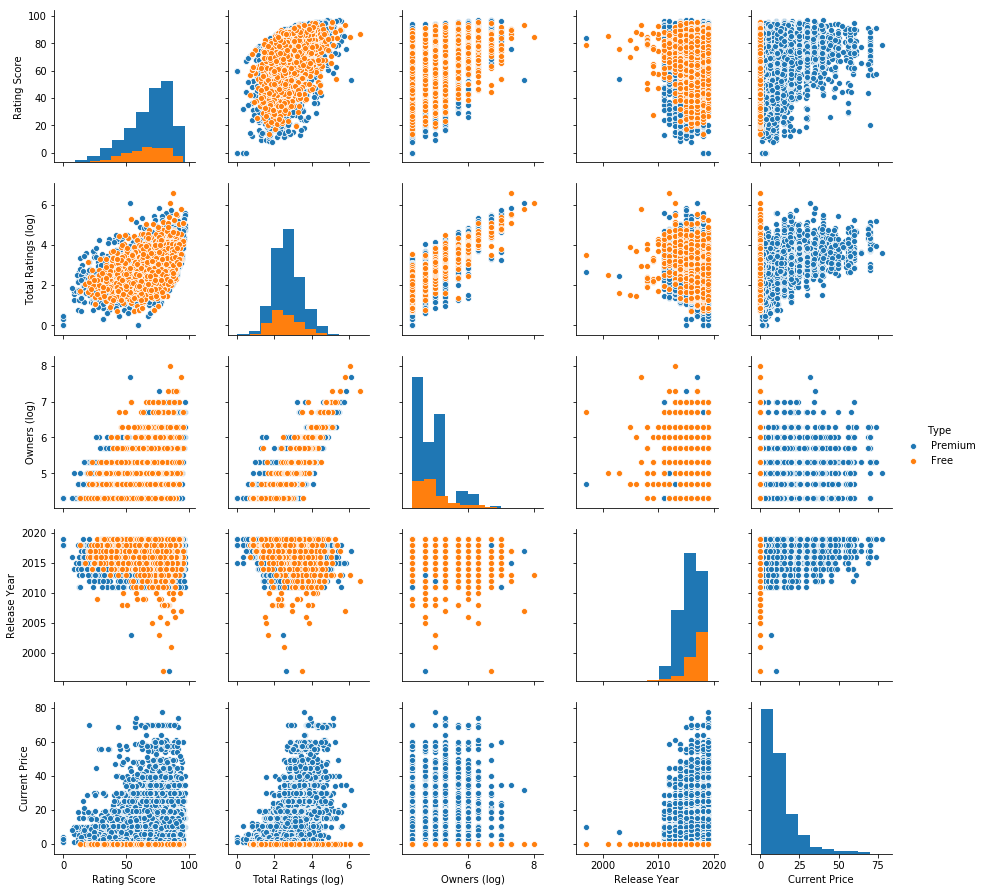

In [6]:
# Create a column to split free vs paid games
pd_data_price=data.copy()
pd_data_price['type'] = 'Free'
pd_data_price.loc[pd_data_price['price'] > 0, 'type'] = 'Premium'

# ensure no 0s in columns we're applying log to
df = pd_data_price[(pd_data_price['owners'] > 0) & (pd_data_price['total_ratings'] > 0)].copy()

eda_df = pd.DataFrame(zip(df['rating'],
                          np.log10(df['total_ratings']),
                          np.log10(df['owners']),
                          df['release_year'],
                          df.price,
                          df['type']
                         ),
                      columns=['Rating Score', 'Total Ratings (log)', 'Owners (log)', 'Release Year', 'Current Price', 'Type'])

sns.pairplot(eda_df, hue='Type', hue_order=['Premium','Free'], diag_kind='hist')
plt.show()

From this observation we can observe several attributes of the dataset and check the difference between premium (orange) and free (blue) games.

We can observe that :
- paid games reach higher ratings than free games, on average
- it looks like there are more owners for paid games than for free games which is interesting as the dataset is composed of more than twice premium games than free games
- in the latest years, more free games have been released than premium games and the price of premium games seems to have increased. 
- most games have a price between 0.- and 20.- CHF. 
- ratings of free games seem to decrease in the last years, same goes for premium games. The conjecture that arises from that is, considering more games are released in the last years, that game's quality have decreased as they seem to earn worse ratings.
- The more owners a game has, the higher its average grade gets. 



## Preparation for the machine learning part 

As we are studying a game success, we will remove of the analysis all the games that are not successful to us, thus having less than or exactly 20'000 owners. As of right now, the number of owners are a string giving a range of number of owners. For pratical issues we will take the middle of the range as the value of number of owners for each game. 

Now we scale the number of owners to the log scale as well as the economic success to fall in with the scale of the rest of the numerical data

In [7]:
pd_data = df.copy()
pd_data['owners'] =  np.log(pd_data['owners'])# /10**6
pd_data['economic_success'] = np.log(pd_data['economic_success']+1)#/10**6
pd_data.head()

,appid,name,release_date,developer,publisher,required_age,genres,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,owners,price,economic_success,total_ratings,rating_ratio,rating,release_year,multi_player,single_player,action,adventure,casual,indie,massively_multiplayer,rpg,racing,simulation,sports,strategy,type
0,340,Half-Life 2: Lost Coast,2005-10-27,Valve,Valve,0,Action,0,6412,1072,123,23,14.508658,0.0,0.0,7484,0.856761,82.754771,2005,0,1,1,0,0,0,0,0,0,0,0,0,Free
1,440,Team Fortress 2,2007-10-10,Valve,Valve,0,Action;Free to Play,520,588020,37107,8895,452,17.727534,0.0,0.0,625127,0.940641,93.217574,2007,1,0,1,0,0,0,0,0,0,0,0,0,Free
2,570,Dota 2,2013-07-09,Valve,Valve,0,Action;Free to Play;Strategy,0,1018172,174020,29989,1284,18.420681,0.0,0.0,1192192,0.854034,84.770535,2013,1,0,1,0,0,0,0,0,0,0,0,1,Free
3,630,Alien Swarm,2010-07-19,Valve,Valve,0,Action,66,17946,974,319,96,13.815511,0.0,0.0,18920,0.948520,92.405605,2010,1,1,1,0,0,0,0,0,0,0,0,0,Free
4,730,Counter-Strike: Global Offensive,2012-08-21,Valve;Hidden Path Entertainment,Valve,0,Action;Free to Play,167,3295593,470639,25886,7129,16.811243,0.0,0.0,3766232,0.875037,87.045099,2012,1,0,1,0,0,0,0,0,0,0,0,0,Free


In [8]:
df_wo_20000 = pd_data[pd_data.owners >= 20000].copy()

In [9]:
#df_wo_20000 = df_wo_20000.drop(columns=['release_date','required_age', 'achievements','positive_ratings','negative_ratings'])
df_wo_20000 = df_wo_20000.dropna()

# Final Dataset after cleaning

Our final dataset consists of a dataset containing the following features : 
- Publisher of the game
- Platform of the game 
- Genre of the game 
- Number of owners of the game
- Release year of the game
- Release month of the game

Each game is identified by : 
- Its full name
- Its Steam identification number

To characterize the success of our game, we introduced two metrics : 
- The economic success 
- The Steam grade

## Machine Learning on features

We can drop some useless features for the machine learning algorithm

In [11]:
from sklearn import metrics
from sklearn.cluster import DBSCAN
from sklearn.datasets.samples_generator import make_blobs
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import validation_curve
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer

In [119]:
ml_data = pd_data.copy()
ml_data = pd_data.drop(columns = ['release_date', 'rating_ratio', 'owners','required_age', 'achievements','positive_ratings','negative_ratings','developer','name','release_year','publisher','genres', 'type'])
ml_data = ml_data.dropna()
ml_data

,appid,average_playtime,median_playtime,price,economic_success,total_ratings,rating,multi_player,single_player,action,adventure,casual,indie,massively_multiplayer,rpg,racing,simulation,sports,strategy
0,340,123,23,0.0,0.000000,7484,82.754771,0,1,1,0,0,0,0,0,0,0,0,0
1,440,8895,452,0.0,0.000000,625127,93.217574,1,0,1,0,0,0,0,0,0,0,0,0
2,570,29989,1284,0.0,0.000000,1192192,84.770535,1,0,1,0,0,0,0,0,0,0,0,1
3,630,319,96,0.0,0.000000,18920,92.405605,1,1,1,0,0,0,0,0,0,0,0,0
4,730,25886,7129,0.0,0.000000,3766232,87.045099,1,0,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29176,1191330,0,0,0.0,0.000000,744,52.972153,1,0,0,0,0,1,1,1,0,0,0,0
29197,1193040,0,0,0.0,0.000000,119,67.422257,1,0,0,0,1,1,0,0,0,0,0,1
29231,1195460,0,0,19.5,14.195659,2548,66.489561,1,0,1,0,0,0,0,0,0,0,0,0
29235,1195820,0,0,3.0,11.561725,3,0.000000,0,1,1,1,0,1,0,0,0,0,0,0


In [120]:
ml_data_eco=ml_data[ml_data.economic_success != 0.0].copy()

In [121]:
num_ml_data = ml_data[ml_data.select_dtypes(include = ['int32','int64','float64']).columns]
num_ml_data.head()

,appid,average_playtime,median_playtime,price,economic_success,total_ratings,rating,multi_player,single_player,action,adventure,casual,indie,massively_multiplayer,rpg,racing,simulation,sports,strategy
0,340,123,23,0.0,0.0,7484,82.754771,0,1,1,0,0,0,0,0,0,0,0,0
1,440,8895,452,0.0,0.0,625127,93.217574,1,0,1,0,0,0,0,0,0,0,0,0
2,570,29989,1284,0.0,0.0,1192192,84.770535,1,0,1,0,0,0,0,0,0,0,0,1
3,630,319,96,0.0,0.0,18920,92.405605,1,1,1,0,0,0,0,0,0,0,0,0
4,730,25886,7129,0.0,0.0,3766232,87.045099,1,0,1,0,0,0,0,0,0,0,0,0


In [122]:
target_ml_data = ml_data[['economic_success','rating']]
features_ml_data = ml_data.drop(columns = ['economic_success','rating'])

In [123]:
target_ml_data_eco = ml_data_eco[['economic_success','rating']]
features_ml_data_eco = ml_data_eco.drop(columns = ['economic_success','rating'])

We split the dataset

In [124]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features_ml_data, target_ml_data, test_size=0.2, random_state=1, shuffle=True)

In [125]:
from sklearn.model_selection import train_test_split

X_train_eco, X_test_eco, y_train_eco, y_test_eco = train_test_split(features_ml_data_eco, target_ml_data_eco, test_size=0.2, random_state=1, shuffle=True)

In [126]:
def plot_validation_curve(train_scores,cv_scores,x_data,scale='lin',title='',y_label='',x_label=''):

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    cv_scores_mean = np.mean(cv_scores, axis=1)
    cv_scores_std = np.std(cv_scores, axis=1)

    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    lw = 2

    plt.fill_between(x_data, train_scores_mean - train_scores_std,train_scores_mean + train_scores_std, alpha=0.2, color="r", lw=lw)
    plt.fill_between(x_data, cv_scores_mean - cv_scores_std, cv_scores_mean + cv_scores_std, alpha=0.2, color="g", lw=lw)

    if (scale == 'lin'):
        plt.plot(x_data, train_scores_mean, 'o-', color="r", label="Training score")
        plt.plot(x_data, cv_scores_mean, 'o-', color="g",label="Cross-validation score")
    elif (scale == 'log'):
        plt.semilogx(x_data, train_scores_mean, 'o-', color="r", label="Training score")
        plt.semilogx(x_data, cv_scores_mean, 'o-', color="g",label="Cross-validation score")
    plt.grid()
    plt.legend(loc="best")
    plt.show()

For feature selection, we will be using the Lasso regression that allows us to obtain the subset of features that minimize the prediction error for a quantitative response variable, in our case, the Steam grade.

In [127]:
lasso_pipeline = make_pipeline(StandardScaler(), Lasso())
cv_schema = StratifiedKFold(n_splits = 5, random_state = 1)
MSE = make_scorer(mean_squared_error)

In [128]:
pd_data.name[9]

'Bone: Out From Boneville'

# Finding which feature has the most impact on each metric

Here we focus on the Steam rating and try to find which are the features that have the greatest importance on it

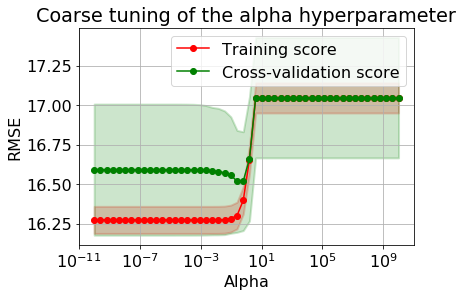

In [129]:
alpha_range = np.logspace(-10, 10, 50)

train_scores_val_l, cv_scores_val_l = validation_curve(lasso_pipeline, X_train, y_train['rating'], param_name="lasso__alpha",
                                                       param_range=alpha_range, cv=5, scoring=MSE,n_jobs = -1)
plot_validation_curve(np.sqrt(train_scores_val_l),np.sqrt(cv_scores_val_l), alpha_range,
                      'log','Coarse tuning of the alpha hyperparameter', 'RMSE', 'Alpha')

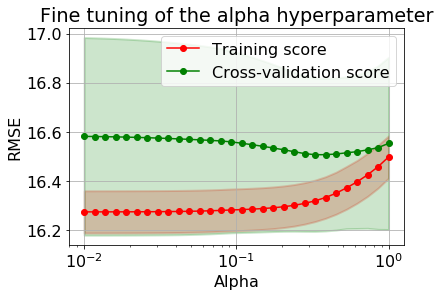

In [130]:
alpha_range_fine = np.logspace(-2, 0, 30)

train_scores_val_l, cv_scores_val_l = validation_curve(lasso_pipeline, X_train, y_train['rating'], param_name="lasso__alpha",
                                                       param_range=alpha_range_fine, cv=5, scoring=MSE,n_jobs = -1)
plot_validation_curve(np.sqrt(train_scores_val_l), np.sqrt(cv_scores_val_l), alpha_range_fine,
                      'log', 'Fine tuning of the alpha hyperparameter', 'RMSE', 'Alpha')

In [131]:
optimal_alpha_l = alpha_range_fine[cv_scores_val_l.mean(axis=1).argmin()]
lasso_pipeline.set_params(lasso__alpha = optimal_alpha_l)

lasso_pipeline.fit(X_train,y_train['rating'])
lasso_predict = lasso_pipeline.predict(X_test)

lasso_regr_rating = np.abs(lasso_pipeline.named_steps['lasso'].coef_.copy())
lasso_regr_rating

array([0.00883652, 0.63432138, 0.        , 3.69200564, 0.65105908,
       0.        , 0.68537795, 0.33293738, 0.22096675, 0.        ,
       1.38308166, 0.56754677, 0.        , 0.32610963, 0.32532508,
       0.        , 0.31367354])

In [132]:
optimal_alpha_l = alpha_range_fine[cv_scores_val_l.mean(axis=1).argmin()]
optimal_alpha_l

0.32903445623126676

In [133]:
feature_zero_steam = X_train.columns[np.where(lasso_regr_rating == 0)[0]]
set_non_zero_features_steam = set(X_train.columns[np.where(lasso_regr_rating != 0)[0]])

# The feature list is ordeed by importance then we keep only the 5 most important features
feature_rating = X_train.columns[np.argsort(lasso_regr_rating)][::-1][1:5]

In [134]:
feature_rating

Index(['indie', 'single_player', 'total_ratings', 'average_playtime'], dtype='object')

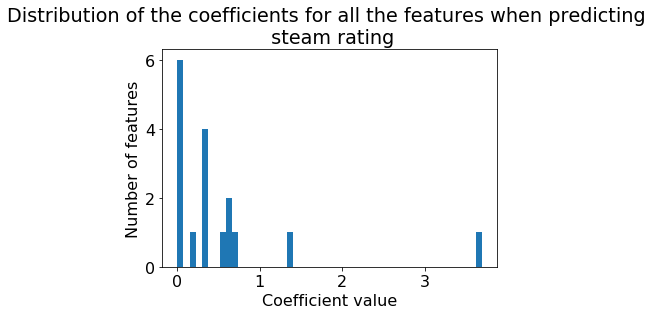

In [135]:
plt.figure(1)
plt.hist(np.abs(lasso_regr_rating),bins=50)
plt.title('Distribution of the coefficients for all the features when predicting \n steam rating')
plt.xlabel('Coefficient value')
plt.ylabel('Number of features')
plt.show()

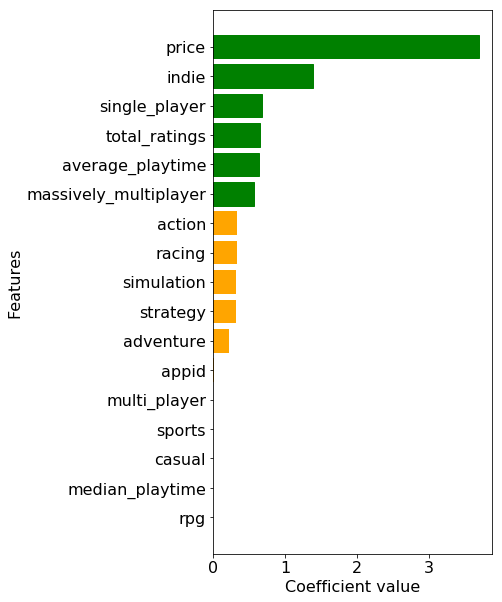

In [136]:
lasso_rating_df = pd.DataFrame([lasso_regr_rating, X_train.columns], index=['coef', 'features']).transpose().sort_values(by=['coef'])

plt.figure(figsize = (5,10))

plt.rcParams.update({'font.size': 16})

barlist = plt.barh(lasso_rating_df.features, lasso_rating_df.coef, 
            color = 'orange')

barlist[-1].set_color('green')
barlist[-2].set_color('green')
barlist[-3].set_color('green')
barlist[-4].set_color('green')
barlist[-5].set_color('green')
barlist[-6].set_color('green')

plt.xlabel('Coefficient value')
plt.ylabel('Features')
plt.savefig('Figures/rating_feat.png', bbox_inches="tight")
plt.show()


Here we can clearly see that what impacts the steam ratings the most is the number of owners, and the rating_ratio, which of course are part of the computation of the rating so it won't give much insight. Nevertheless, this analysis, helps us see the correlation between the rating and the price and the games genres that have the biggest impact on economic success (indie, simulation and casual).

In this section we will conduct the same analysis but this time on the economic success, our second metric of success : 

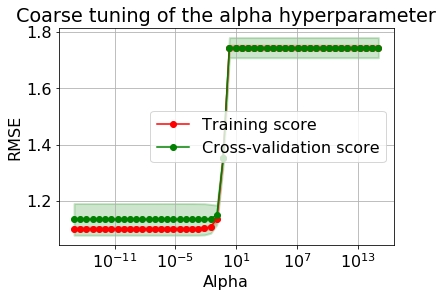

In [137]:
alpha_range = np.logspace(-15, 15, 50)

train_scores_val_l, cv_scores_val_l = validation_curve(lasso_pipeline, X_train_eco, y_train_eco['economic_success'], param_name="lasso__alpha",
                                                       param_range=alpha_range, cv=5, scoring=MSE,n_jobs = -1)
plot_validation_curve(np.sqrt(train_scores_val_l),np.sqrt(cv_scores_val_l), alpha_range,
                      'log','Coarse tuning of the alpha hyperparameter', 'RMSE', 'Alpha')

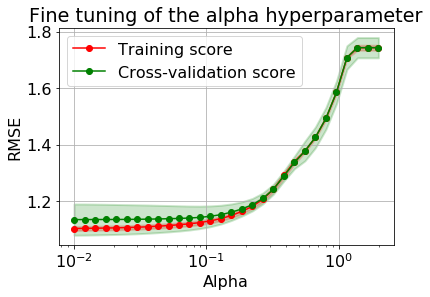

In [138]:
alpha_range_fine = np.logspace(-2, 0.3, 30)

train_scores_val_l, cv_scores_val_l = validation_curve(lasso_pipeline, X_train_eco, y_train_eco['economic_success'], param_name="lasso__alpha",
                                                       param_range=alpha_range_fine, cv=5, scoring=MSE,n_jobs = -1)
plot_validation_curve(np.sqrt(train_scores_val_l), np.sqrt(cv_scores_val_l), alpha_range_fine,
                      'log', 'Fine tuning of the alpha hyperparameter', 'RMSE', 'Alpha')

In [139]:
optimal_alpha_l = alpha_range_fine[cv_scores_val_l.mean(axis=1).argmin()]
lasso_pipeline.set_params(lasso__alpha = optimal_alpha_l)

lasso_pipeline.fit(X_train_eco,y_train_eco['economic_success'])
lasso_predict = lasso_pipeline.predict(X_test_eco)

lasso_regr_economic_success = np.abs(lasso_pipeline.named_steps['lasso'].coef_.copy())
lasso_regr_economic_success

array([0.40535783, 0.11541213, 0.05391211, 1.08674824, 0.3097247 ,
       0.10290007, 0.02353401, 0.02213587, 0.05048858, 0.08828959,
       0.        , 0.        , 0.03640624, 0.00985512, 0.07447453,
       0.02042736, 0.02831436])

In [140]:
feature_zero_steam = X_train_eco.columns[np.where(lasso_regr_economic_success == 0)[0]]
set_non_zero_features_steam = set(X_train_eco.columns[np.where(lasso_regr_economic_success != 0)[0]])

# The feature list is ordeed by importance then we keep only the 5 most important features
feature_economic_success = X_train_eco.columns[np.argsort(lasso_regr_economic_success)][::-1][1:5]

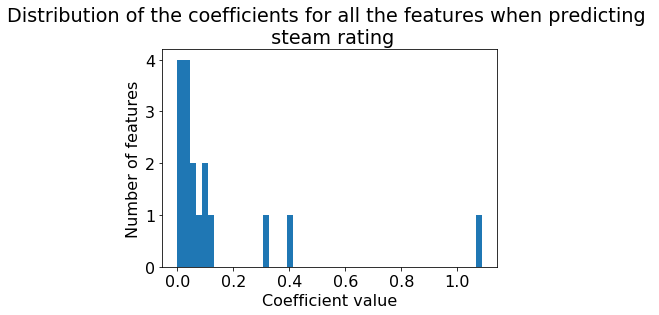

In [141]:
plt.figure(1)
plt.hist(np.abs(lasso_regr_economic_success),bins=50)
plt.title('Distribution of the coefficients for all the features when predicting \n steam rating')
plt.xlabel('Coefficient value')
plt.ylabel('Number of features')
plt.show()

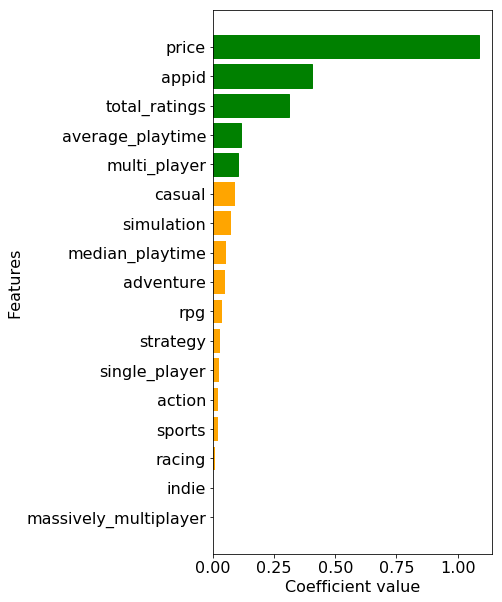

In [142]:
lasso_economic_success_df = pd.DataFrame([lasso_regr_economic_success, X_train_eco.columns], index=['coef', 'features']).transpose().sort_values(by=['coef'])

plt.figure(figsize = (5,10))

plt.rcParams.update({'font.size': 16})

barlist = plt.barh(lasso_economic_success_df.features, lasso_economic_success_df.coef, 
            color = 'orange')

barlist[-1].set_color('green')
barlist[-2].set_color('green')
barlist[-3].set_color('green')
barlist[-4].set_color('green')
barlist[-5].set_color('green')

plt.xlabel('Coefficient value')
plt.ylabel('Features' )
plt.savefig('Figures/eco_sucess_feat.png', bbox_inches="tight")
plt.show()

Here we can clearly see that what impacts the economic success the most is the number of owners, and the price, which of course are its principal components so it won't give much insight. Nevertheless, this analysis, helps us see the correlation between the rating and the economic success and the games genres that have the biggest impact on economic success (simulation and casual).

# From this analysis, and combining the two observations, we will decide to only keep the 5 features that impact our metrics the best for our graph theory analysis. 

These features are : 
- for the steam rating :  price, owners, indie, simulation, casual
- for the economic success :  price, owners, simulation, casual, multiplayer